In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import urllib3
from bs4 import BeautifulSoup
import re
import warnings
import statsmodels.formula.api as smf
import time

In [2]:
# get IPO data from AASTOCKS

# initialze empty list
combined_data_list = []

# loop through 20 pages
for page in range(1,20):    
    url = "http://www.aastocks.com/en/ipo/listedipo.aspx?iid=ALL&orderby=DA&value=DESC&index=%d" % page

    # query the website and return the html
    http = urllib3.PoolManager()
    response = http.request('GET', url)
    soup = BeautifulSoup(response.data,"lxml")

    # find the right_table
    all_tables = soup.find_all('table')
    right_table = soup.find('table',class_='newIPOTable')

    # initialze empty list
    data_list = []
    
    # find row location
    for row in right_table.findAll("tr"):
        # find the data inside td/a/span tags
        for data in row.findAll(['td','a','span']):
            data_list.append(data.find(text=True))             
            
    # preprocess data
    def preprocessing(data_list):
        data_list = [data.strip() for data in data_list if isinstance(data, str)]
        data_list = list(filter(None,data_list))

        return data_list
    
    data_list = preprocessing(data_list)[12:]
    combined_data_list.extend(data_list)
    
    time.sleep(5)

In [3]:
# convert data from list to dataframe
col_names = ['listing_date',
             'symbol',
             'name',
             'industry',
             'issue_price',
             'over_sub_rate',
             'secure_one_lot',
             'one_lot_sucess_rate', 
             'pct_chg_on_list_day',
             'last_price',
             'accumlated_pct_chg']

n_col = len(col_names)
n_row = int(len(combined_data_list)/len(col_names))
df = pd.DataFrame(np.array(combined_data_list).reshape(n_row,n_col),columns=col_names)

In [4]:
# data cleansing and transformation

# replace 'Under-Sub.' as 0
df.replace('Under-Sub.',0,inplace=True)

# drop if NA 
df = df.replace('N/A',np.nan).dropna()

# parse Date
df['listing_date'] = pd.to_datetime(df['listing_date'])

# convert str to float
df[['issue_price','over_sub_rate','last_price']] = df[['issue_price','over_sub_rate','last_price']].astype(float)

# convert str% to float
str_pct_to_float = lambda x: (x.str.replace('%','').astype(float))/100
df[['pct_chg_on_list_day','one_lot_sucess_rate','accumlated_pct_chg']] = \
df[['pct_chg_on_list_day','one_lot_sucess_rate','accumlated_pct_chg']].apply(str_pct_to_float)

# convert str to int
df['secure_one_lot'] = df['secure_one_lot'].astype(int)

# create expected return on list day
df['exp_pct_chg_on_list_day'] = df['one_lot_sucess_rate']*df['pct_chg_on_list_day']

In [5]:
# concat with past data if it was stored as 'data.csv'
try:
    df_past = pd.read_csv('data.csv')
    df = pd.concat((df,df)).drop_duplicates(subset='symbol')
except:
    pass

# save as data.csv so we can accmulate the data
df.to_csv('data.csv',index=False)

In [6]:
# check top 20 rows
df.sort_values(by='pct_chg_on_list_day',ascending=False,inplace=True)
df.head(20)

,listing_date,symbol,name,industry,issue_price,over_sub_rate,secure_one_lot,one_lot_sucess_rate,pct_chg_on_list_day,last_price,accumlated_pct_chg,exp_pct_chg_on_list_day
23,2018-03-28,01716,MOST KWAI CHUNG,Multi-media Enterprise,1.20,6288.0,1000,0.008,4.3167,2.810,1.3417,0.034534
33,2018-03-14,01705,B & S INTL HLDG,Packaged Foods,1.00,2599.5,500,0.030,2.9800,2.150,1.1500,0.089400
59,2018-01-29,01711,ULFERTS,Furniture & Household Goods,0.56,1638.0,400,0.100,1.8571,0.520,-0.0714,0.185710
235,2017-03-08,01985,MICROWARE,IT Hardware,1.46,1176.8,100,0.500,1.7397,1.350,-0.0753,0.869850
186,2017-07-11,01695,S&P INTL HLDG,Food Additives & Flavouring,0.48,8.4,7,0.401,1.5833,0.300,-0.3750,0.634903
168,2017-07-19,08427,SK TARGET,Construction Materials,0.28,11.2,1,1.000,1.5000,0.305,0.0893,1.500000
66,2018-01-19,08043,ATLINKS,Telecomm. & Networking Equipment,0.50,10.4,70,0.300,1.4000,0.380,-0.2400,0.420000
334,2016-07-13,01573,CH UNIENERGY,Coal,1.80,0.0,1,1.000,1.3000,8.000,3.4444,1.300000
76,2018-01-16,08487,ISP GLOBAL,IT Hardware,0.35,10.0,15,0.088,1.2286,2.690,6.6857,0.108117
128,2017-11-09,01720,PUTIAN COMM,Telecomm. & Networking Equipment,0.66,9.9,15,0.075,1.2121,2.670,3.0455,0.090907


In [7]:
# data date range
date_from = np.min(df['listing_date'])
date_to = np.max(df['listing_date'])
print('Data date range: from {:%Y-%m-%d} to {:%Y-%m-%d}'.format(date_from,date_to))

Data date range: from 2016-06-01 to 2018-05-18


In [8]:
# inspect data
print(df.describe()[[
    'over_sub_rate',
    'secure_one_lot',
    'one_lot_sucess_rate',
    'pct_chg_on_list_day',
    'exp_pct_chg_on_list_day'
]])

       over_sub_rate  secure_one_lot  one_lot_sucess_rate  \
count     289.000000      289.000000           289.000000   
mean      185.971626       41.802768             0.691682   
std       508.722441      114.400972             0.335117   
min         0.000000        1.000000             0.008000   
25%         4.500000        1.000000             0.400000   
50%        18.900000        3.000000             0.800000   
75%       127.000000       25.000000             1.000000   
max      6288.000000     1000.000000             1.000000   

       pct_chg_on_list_day  exp_pct_chg_on_list_day  
count           289.000000               289.000000  
mean              0.178752                 0.087277  
std               0.447259                 0.226036  
min              -0.280000                -0.280000  
25%               0.000000                 0.000000  
50%               0.046700                 0.020000  
75%               0.180400                 0.095500  
max               

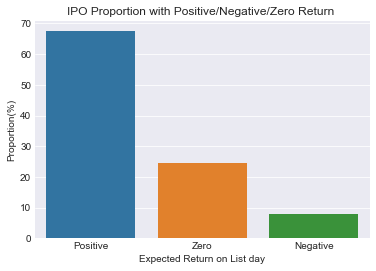

In [9]:
# Positive/Negative/Zero Return Count
sign_dict = {1.0:'Positive',0.0:'Zero',-1.0:'Negative'}
pos_neg_return_prop = pd.Series(
    np.sign(df['exp_pct_chg_on_list_day']).map(sign_dict)).value_counts(normalize=True)*100 
sns.barplot([sign_dict[i] for i in np.arange(1,-2,-1)],pos_neg_return_prop)
plt.xlabel('Expected Return on List day')
plt.ylabel('Proportion(%)')
plt.title('IPO Proportion with Positive/Negative/Zero Return ')
plt.show()

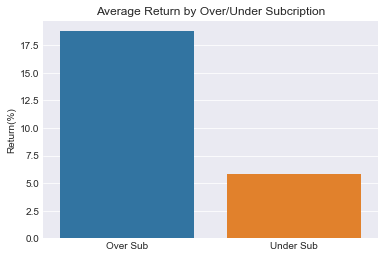

In [10]:
# Positive/Negative/Zero Return Count
sign_dict = {1.0:'Over Sub',0.0:'Under Sub'}
over_under_sub_return = df.groupby(np.sign(df['over_sub_rate']).map(sign_dict))['pct_chg_on_list_day'].mean()*100 
sns.barplot([sign_dict[1],sign_dict[0]],over_under_sub_return)
plt.ylabel('Return(%)')
plt.title('Average Return by Over/Under Subcription')
plt.show()

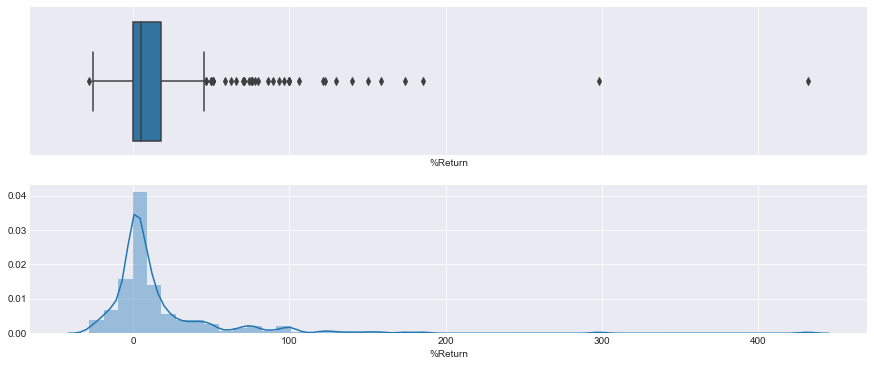

In [11]:
fig,axes = plt.subplots(2,1,figsize=(15,6),sharex=True)
sns.boxplot((df['pct_chg_on_list_day'])*100,ax=axes[0])
sns.distplot((df['pct_chg_on_list_day'])*100,ax=axes[1]) 
for ax in axes:
    ax.set_xlabel('%Return')
plt.show()

In [12]:
# best performers
print('The Best 5 Performers on List day')
print(df.sort_values(by='pct_chg_on_list_day',ascending=False)[['name','symbol','pct_chg_on_list_day']].set_index(
    'symbol')[:5],'\n')

# worst performers
print('The Worst 5 Performers on List day')
print(df.sort_values(by='pct_chg_on_list_day',ascending=True)[['name','symbol','pct_chg_on_list_day']].set_index(
    'symbol')[:5])

The Best 5 Performers on List day
                   name  pct_chg_on_list_day
symbol                                      
01716   MOST KWAI CHUNG               4.3167
01705   B & S INTL HLDG               2.9800
01711           ULFERTS               1.8571
01985         MICROWARE               1.7397
01695     S&P INTL HLDG               1.5833 

The Worst 5 Performers on List day
                  name  pct_chg_on_list_day
symbol                                     
08362    WINNING TOWER              -0.2800
01962     EVERGREEN PG              -0.2606
03358   BESTWAY GLOBAL              -0.2420
08511       ZC TECH GP              -0.2385
08360         AL GROUP              -0.2344


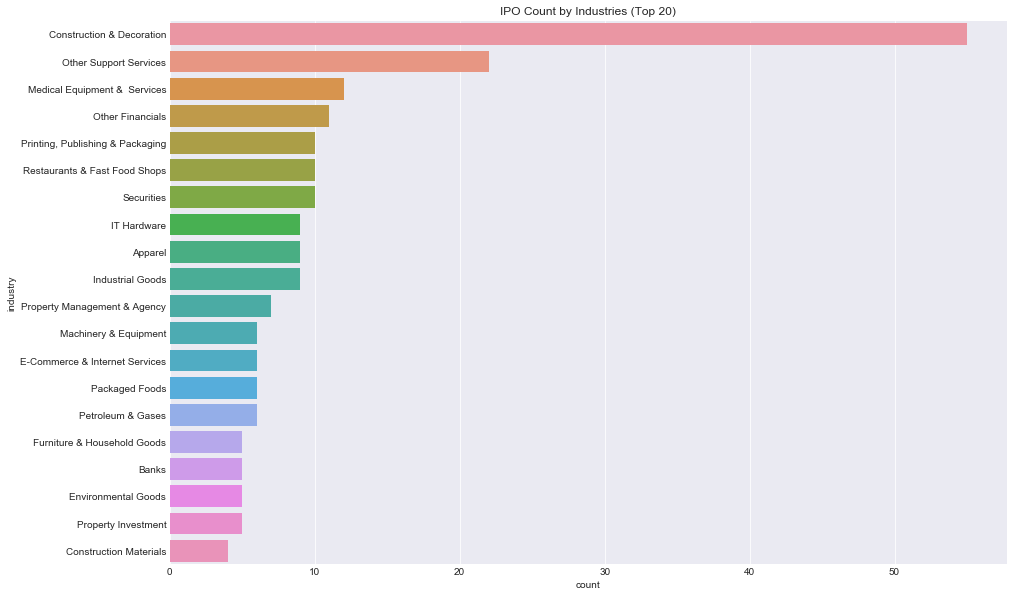

In [13]:
# Count By industry plot
plt.figure(figsize=(15,10))
sns.countplot(y='industry',data=df,order=df['industry'].value_counts().index[:20])
plt.title('IPO Count by Industries (Top 20)')
plt.show()

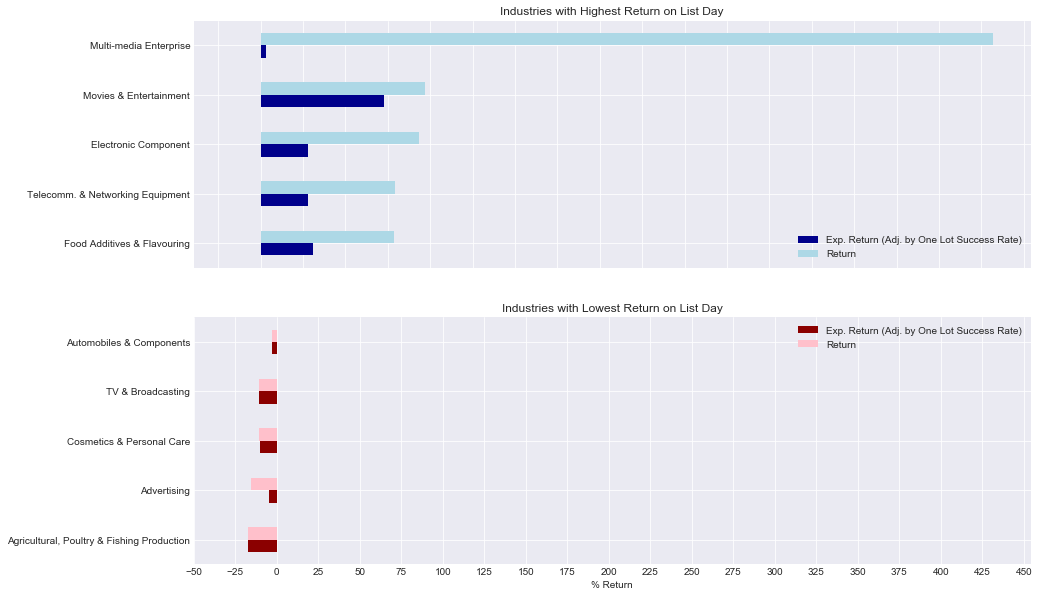

In [14]:
# list day return by industry plot
sns.set_style('darkgrid')
return_by_industry = df.pivot_table(values=['pct_chg_on_list_day','exp_pct_chg_on_list_day'],index='industry')*100

fig,axes = plt.subplots(2,1,figsize=(15,10),sharex=True)

# axes[0]
return_by_industry.sort_values(by='pct_chg_on_list_day')[-5:].plot.barh(
    ax=axes[0],color=['darkblue','lightblue'])

axes[0].set_title('Industries with Highest Return on List Day')

return_by_industry.sort_values(
by='pct_chg_on_list_day')[:5].plot.barh(
    ax=axes[1],color=['darkred','pink'])

# axes[1]
axes[1].set_title('Industries with Lowest Return on List Day')

# layout for both axes
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('% Return')
    ax.legend(['Exp. Return (Adj. by One Lot Success Rate)','Return'])
    
# round up and down by x ticks
round_down_25 = lambda x: x - x%25 -25
round_up_25 = lambda x: x + x%25 +25
    
plt.xticks(np.arange(round_down_25(np.min(np.min(return_by_industry))), 
                     round_up_25(np.max(np.max(return_by_industry))),25.0))
plt.show()

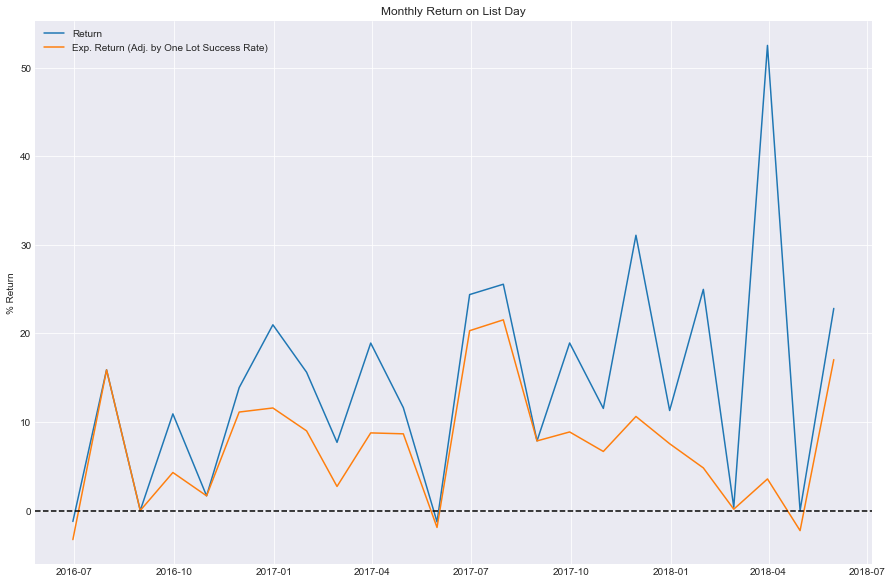

In [15]:
# average monthly return on list day
plt.figure(figsize=(15,10))
plt.plot((df.groupby(pd.Grouper(key='listing_date', freq='M'))['pct_chg_on_list_day'].mean())*100,
         label='Return')
plt.plot((df.groupby(pd.Grouper(key='listing_date', freq='M'))['exp_pct_chg_on_list_day'].mean())*100,
         label='Exp. Return (Adj. by One Lot Success Rate)')
plt.axhline(linestyle='--',color='black')
plt.title('Monthly Return on List Day')
plt.ylabel('% Return')
plt.legend()
plt.show()

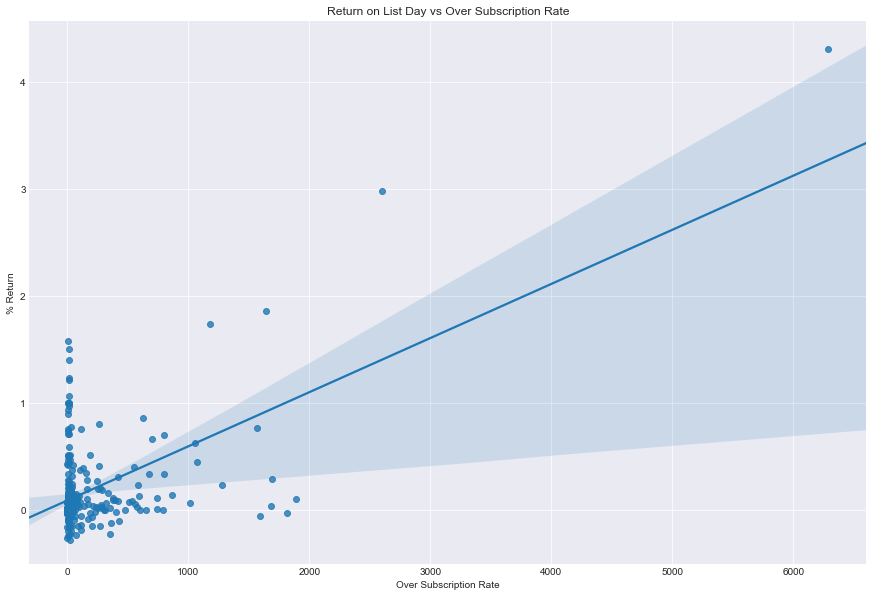

                             OLS Regression Results                            
Dep. Variable:     pct_chg_on_list_day   R-squared:                       0.341
Model:                             OLS   Adj. R-squared:                  0.339
Method:                  Least Squares   F-statistic:                     138.4
Date:                 Mon, 28 May 2018   Prob (F-statistic):           5.13e-26
Time:                         21:32:40   Log-Likelihood:                -113.28
No. Observations:                  269   AIC:                             230.6
Df Residuals:                      267   BIC:                             237.8
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0865      0.024 

In [16]:
# how return on list day relates to over_sub_rate (Excl. under sub)
plt.figure(figsize=(15,10))
sns.regplot(df[df['over_sub_rate']>0]['over_sub_rate'],
            df[df['over_sub_rate']>0]['pct_chg_on_list_day'])
plt.title('Return on List Day vs Over Subscription Rate')
plt.ylabel('% Return')
plt.xlabel('Over Subscription Rate')
plt.show()

print(smf.ols('pct_chg_on_list_day ~ over_sub_rate',data=df[df['over_sub_rate']>0]).fit().summary())